In [1]:
import torch  
from tqdm.autonotebook import tqdm
from tools.datasets_tools import load_dataset, create_splits
from tools.datasets_tools import get_occupation_labels, load_embeddings
from tools.model_utils import get_model

/tmp/ipykernel_3838142/189464579.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
baseline = 'normal' 
#baseline = 'nogender'

#modeltype, nb_epochs = 'RoBERTa', 10
#modeltype, nb_epochs = 'DeBERTa', 3
modeltype, nb_epochs = 'DistilBERT', 3

basesavepath = "/data/fanny.jourdan/TaCo_baseline/"

if baseline == "normal":
  datafolder = "/datasets/shared_datasets/BIOS/"
  model_path = f"/datasets/shared_datasets/BIOS/models/{modeltype}_occBIOS_{nb_epochs}epochs_g1"  # predict occ
elif baseline == 'nogender':
  datafolder = "/datasets/shared_datasets/BIOS_ng/"
  model_path = f"/datasets/shared_datasets/BIOS_ng/models/{modeltype}_occBIOS_{nb_epochs}epochs_ng1"  # predict occ

else:
  print("Baseline not found")

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dt_X, gender_names, occ_names = load_dataset(datafolder)
splits, genders = create_splits(dt_X)
model, tokenizer = get_model(model_path, model_type = modeltype)
dt_X_train, dt_X_val, dt_X_test = splits
gender_train, gender_val, gender_test = genders

In [4]:
dt_X

,sentence,gender,label
0,She is also a Ronald D. Asmus Policy Entrepre...,0,3
1,He is a member of the AICPA and WICPA. Brent ...,1,23
2,Dr Aster has held teaching and research posit...,1,3
3,She currently works on CNN’s newest primetime...,0,12
4,He runs a boutique design studio attending cl...,1,13
...,...,...,...
388857,Fernando focuses his practice in all forms of...,1,14
388858,He maintains the trade policy site url. Rajan...,1,3
388859,"She teaches courses in Technical Writing, Com...",0,3
388860,He has been responsible for many facets of fi...,1,23


In [5]:
from tools.utils import batch_predict

ntest = 50
features_ntest, labels_ntest = batch_predict(model.features, tokenizer, dt_X_test[:ntest], 32, device)
ypred_bis_ntest = model.end_model(features_ntest)

ypred_ntest, labels_ntest = batch_predict(model.forward, tokenizer, dt_X_test[:ntest], 32, device)

print("accuracy for classic model:", torch.mean((torch.argmax(ypred_ntest, -1) == labels_ntest).float()))
print("accuracy for model in 'two parts':", torch.mean((torch.argmax(ypred_bis_ntest, -1) == labels_ntest).float()))

100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


accuracy for classic model: tensor(0.8600, device='cuda:0')
accuracy for model in 'two parts': tensor(0.8400, device='cuda:0')


### Load (or run) CLS tokens (embeddings)

In [5]:
datasets = dt_X_train, dt_X_val, dt_X_test
train_val_test_clstoken, train_val_test_labels = load_embeddings(datasets,
                                                                 model=model,
                                                                 tokenizer=tokenizer,
                                                                 path=basesavepath,
                                                                 baseline=baseline,
                                                                 regenerate=False,
                                                                 model_type=modeltype,
                                                                 device=device)
train_clstoken, val_clstoken, test_clstoken = train_val_test_clstoken
train_labels, val_labels, test_labels = train_val_test_labels


train_labels, val_labels, test_labels = get_occupation_labels(dt_X_train, dt_X_val, dt_X_test, device)

In [6]:
ypred_test = model.end_model(test_clstoken)
print("accuracy for classic model:", torch.mean((torch.argmax(ypred_test, -1) == test_labels).float()))

accuracy for classic model: tensor(0.8616, device='cuda:0')


In [10]:
train_clstoken.shape, val_clstoken.shape, test_clstoken.shape

(torch.Size([38886, 768]), torch.Size([77773, 768]))

In [11]:
train_labels.shape, val_labels.shape, test_labels.shape

(torch.Size([272203]), torch.Size([38886]), torch.Size([77773]))

In [12]:
gender_train.shape, gender_val.shape, gender_test.shape

((272203,), (38886,), (77773,))

# Train Model to predict gender

In [14]:
from tools.train import train_genders, LogisticMLP


retrain_gender_model = False
mlp_or_lin = 'mlp'
real_dataset = (train_clstoken, val_clstoken, test_clstoken)
save_name = basesavepath + f'gender_pred/{modeltype}_{mlp_or_lin}_baseline_{baseline}.pt'
if retrain_gender_model:
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=200,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          save_path_and_name=save_name)
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_clstoken.shape[1]
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_model = train_genders(real_dataset, genders,
                          batch_size=2048, test_batch_size=8192,
                          learning_rate=1e-3, epochs=0,
                          train_on_validation_set=True,
                          model_type=mlp_or_lin,
                          state_dict=state_dict)

Final evaluation on the test set:

Val set: Average loss: 0.0759, Accuracy: 76517/77773 (98.385%)


Train to predict gender from occupation

Accuracy: 62.679%


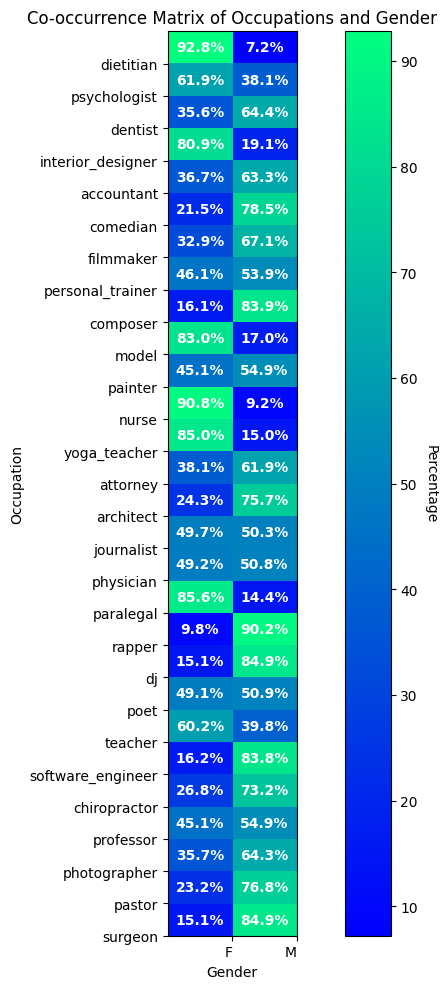

In [14]:
import numpy as np
from tools.train import predict_gender_from_occupation

occupation_dataset = (train_labels, val_labels, test_labels)
predict_gender_from_occupation(occupation_dataset, genders)

# PART 1: Matrix decomposition

In [19]:
clstoken = torch.cat((train_clstoken, val_clstoken, test_clstoken), dim=0)

#refill the tensors:
n_train, n_val, n_test = len(train_clstoken), len(val_clstoken), len(test_cls_token)
#train_features_new, val_features_new, test_features_new = features.split((n_train, n_val, n_test), dim=0)

In [21]:
from TaCo.decomposition import decompose_choice

method_name = "ICA"
num_components = 20
decomposition_method = decompose_choice(method_name, num_components)


U, W = decomposition_method.decompose(clstoken)

U_train, U_val, U_test = U.split((n_train, n_val, n_test), dim=0)

num_components: 20


# Visualisation of Latent Space

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from umap import UMAP 
from sklearn.cluster import KMeans

umap_2d = UMAP(n_components=2, init='random', random_state=0)
matrix = umap_2d.fit_transform(train_features)

gender_plot = gender_train
labels_plot = train_labels.cpu().numpy().astype(int)

gender_names = ['Female', 'Male']
occ_names = ['surgeon', 'pastor', 'photographer', 'professor', 'chiropractor', 'software_engineer', 'teacher', 'poet', 
             'dj', 'rapper', 'paralegal', 'physician', 'journalist', 'architect', 'attorney', 'yoga_teacher', 'nurse', 
             'painter', 'model', 'composer', 'personal_trainer', 'filmmaker', 'comedian', 'accountant', 'interior_designer', 
             'dentist', 'psychologist', 'dietitian']

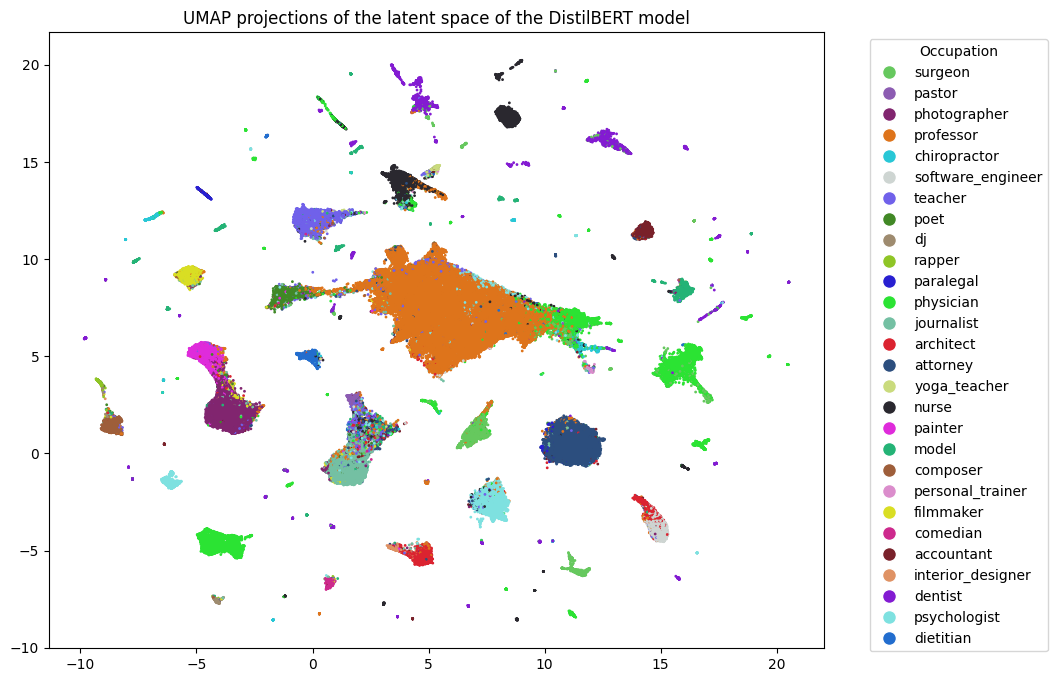

In [81]:
#occupations
#palette = sns.color_palette("husl", 28)

np.random.seed(3)
n_colors = 28
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(np.random.rand(1000, 3))
palette = kmeans.cluster_centers_
colors = [palette[label] for label in labels_plot]


plt.figure(figsize=(10, 8))
scatter = plt.scatter(matrix[:, 0], matrix[:, 1], c=colors, s=1)

legend_labels = {i: name for i, name in enumerate(occ_names)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=name) for i, name in enumerate(occ_names)]
plt.legend(handles=handles, title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP projections of the latent space of the DistilBERT model')
plt.show()

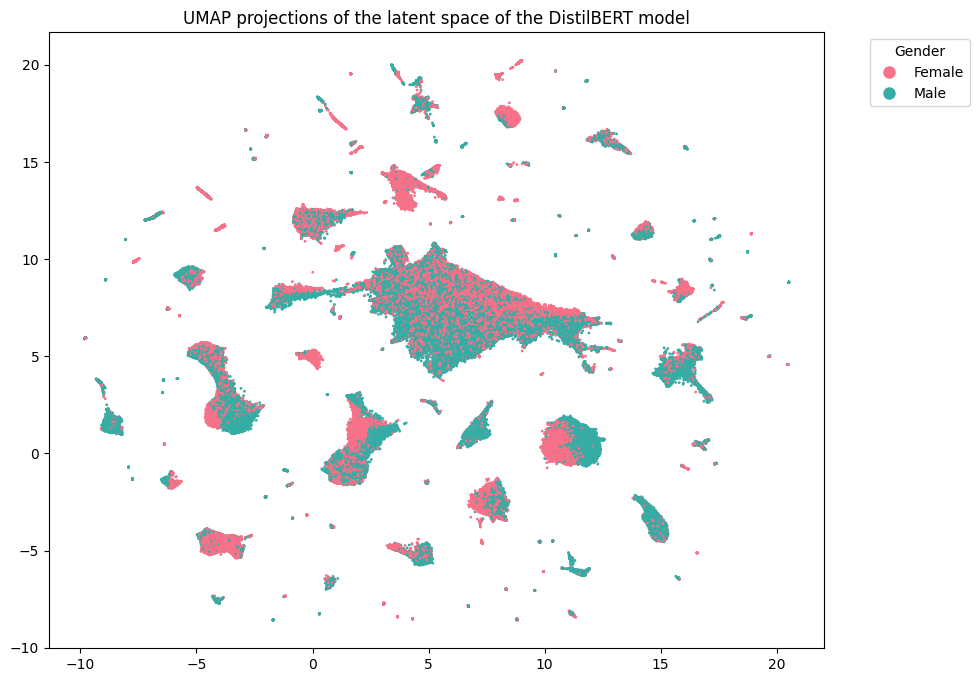

In [82]:
#gender
palette = sns.color_palette("husl", 2)
colors = [palette[label] for label in gender_plot]


plt.figure(figsize=(10, 8))
scatter = plt.scatter(matrix[:, 0], matrix[:, 1], c=colors, s=1)

legend_labels = {i: name for i, name in enumerate(gender_names)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=name) for i, name in enumerate(gender_names)]
plt.legend(handles=handles, title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP projections of the latent space of the DistilBERT model')
plt.show()

# PART 2: Ranking concepts (Sobol)

In [ ]:
from TaCo.concept_removal import sobol_importance_from_sample

sobol_nb_design = 50
sampled = 10_000

pg_model.eval() 
global_importance_gender, rel_errors_all_masks = sobol_importance_from_sample(train_clstoken, U_train.numpy(),
                                                                              W.numpy(), pg_model,
                                                                              sampled=sampled,
                                                                              num_components=num_components,
                                                                              sobol_nb_design=sobol_nb_design, 
                                                                              device=device)

100%|██████████| 10000/10000 [01:13<00:00, 135.22it/s]


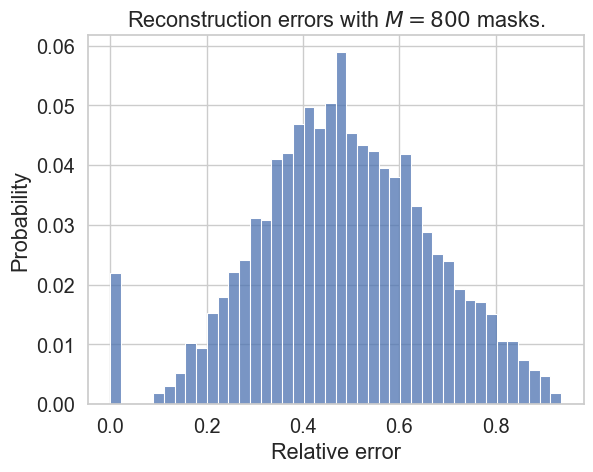

In [ ]:
from tools.visualization import plot_reconstruction_error
import matplotlib.pyplot as plt

plot_reconstruction_error(rel_errors_all_masks)

In [ ]:
model.eval()
model_occ = lambda x: model.end_model(x)
global_importance_occ, _ = sobol_importance_from_sample(train_clstoken, U_train.numpy(),
                                                        W.numpy(), model_occ,
                                                        sampled=sampled,
                                                        num_components=num_components,
                                                        sobol_nb_design=sobol_nb_design,
                                                        device=device)

100%|██████████| 10000/10000 [00:34<00:00, 288.99it/s]


In [ ]:
import pickle
pickle.dump(global_importance_gender, open(f'global_importance/{modeltype}_gi_gender_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))
pickle.dump(global_importance_occ, open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"wb"))

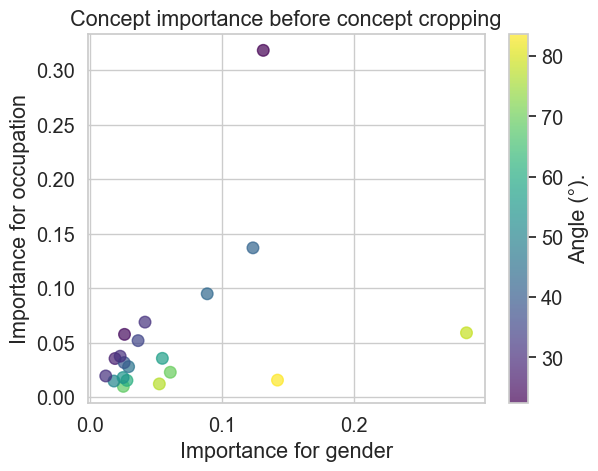

In [ ]:
from tools.visualization import plot_co_importance
plot_co_importance(global_importance_occ, global_importance_gender)

# PART 3: Remove concepts

In [ ]:
import pickle
global_importance_gender = pickle.load(open(f'global_importance/gi_gender_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))
global_importance_occ = pickle.load(open(f'global_importance/gi_occupation_{modeltype}_{method_name}{num_components}_{mlp_or_lin}_baseline_{baseline}.pkl',"rb"))


In [ ]:
import numpy as np

W_gender_max = np.argmax(global_importance_gender)
f"idx={W_gender_max} concepts={global_importance_gender}"

'idx=15 concepts=[0.14178646 0.05222078 0.0249336  0.01785744 0.06052642 0.01160619\n 0.02766768 0.02475148 0.02891916 0.0186421  0.0255727  0.05451784\n 0.03610014 0.02582682 0.02251817 0.285038   0.04136292 0.08850759\n 0.1231896  0.13099605]'

In [ ]:
W_occ_max = np.argmax(global_importance_occ)
f"idx={W_occ_max} concepts={global_importance_occ}"

'idx=19 concepts=[0.01558847 0.01211336 0.00987153 0.01473458 0.02279549 0.01940823\n 0.01533164 0.0179653  0.02791209 0.0353743  0.03164991 0.03555777\n 0.05181019 0.05754033 0.03750351 0.05897734 0.06878164 0.0947592\n 0.13689709 0.31800368]'

In [ ]:
from TaCo.concept_removal import crop_concepts, build_gender_neutral_features

nb_cpt_remov = 1
angle = np.arctan(global_importance_occ / global_importance_gender) * 180 / np.pi
W_no_gender, to_keep = crop_concepts(W.numpy(), angle, num_or_threshold=num_components-nb_cpt_remov)

train_clstoken_no_gender = build_gender_neutral_features(U_train.numpy(), W_no_gender, to_keep)
val_clstoken_no_gender = build_gender_neutral_features(U_val.numpy(), W_no_gender, to_keep)
test_clstoken_no_gender = build_gender_neutral_features(U_test.numpy(), W_no_gender, to_keep)

train_clstoken_no_gender.shape, val_clstoken_no_gender.shape, test_clstoken_no_gender.shape


((272203, 768), (38886, 768), (77773, 768))

# Training new model without gender information

In [ ]:
retrain = False
save_name = basesavepath + f'no_gender/pred_g_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_clstoken_no_gender, val_clstoken_no_gender, test_clstoken_no_gender

def to_cuda_tensor(arr):
    return torch.Tensor(arr).type(torch.FloatTensor).to(device)

real_dataset = tuple(map(to_cuda_tensor, real_dataset))

if retrain:
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=100,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     save_path_and_name=save_name)
else:
  state_dict = torch.load(save_name, map_location=torch.device(device))
  pg_no_gender_model = train_genders(real_dataset, genders,
                                     batch_size=2048, test_batch_size=8192,
                                     learning_rate=5e-4, epochs=0,
                                     train_on_validation_set=True,
                                     model_type='mlp',
                                     state_dict=state_dict,
                                     save_path_and_name=save_name)

Final evaluation on the test set:

Val set: Average loss: 1.8713, Accuracy: 51940/77773 (66.784%)


In [ ]:
from tools.train import train_occupations

retrain = False
save_path = basesavepath + f'no_gender/pred_occ_{method_name}{num_components}_cr{nb_cpt_remov}_{modeltype}_b_{baseline}.pt'
real_dataset = train_clstoken_no_gender, val_clstoken_no_gender, test_clstoken_no_gender
occupations = train_labels, val_labels, test_labels
if retrain:
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=100,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           save_path_and_name=save_path)
                                          
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  in_features = train_clstoken_no_gender.shape[1]
  state_dict = torch.load(save_path, map_location=torch.device(device))
  pocc_no_gender_model = train_occupations(real_dataset, occupations,
                                           batch_size=2048, val_batch_size=8192,
                                           learning_rate=5e-4, epochs=0,
                                           train_on_validation_set=False,
                                           model_type='mlp',
                                           state_dict=state_dict,
                                           save_path_and_name=None)
                                           

Final evaluation on test set:

Val set: Average loss: 3.3035, Accuracy: 50637/77773 (65.109%)
